# Assignment1 - Part B

### Step 01: Import pyspark and initialize Spark

In [1]:
# if you dont have pyspark on your own laptop, please pip it to install
# !pip install pyspark

import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'
#import SparkContext, SparkConf, and SparkSession
from pyspark import SparkContext, SparkConf 
from pyspark.sql import SparkSession

# Create or get an SparkContext
sc = SparkContext.getOrCreate()

# If there is no existing spark context, we now create a new context, I decide to use 3 cores
if (sc is None):
    sc = SparkContext(master="local[3]", appName="FIT5202 Assignment1-B")

spark = SparkSession(sparkContext=sc)\
        .builder\
        .appName("FIT5202 Assignment1-B")\
        .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0")\
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/fit5202_assignment1_db.partb")\
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/fit5202_assignment1_db.partb")\
        .getOrCreate()

### Step 02: Create Dataframe

In [2]:
# Data Frame of Crime
crime_rdd = spark.read.csv('/Users/frank/Desktop/Sem4/FIT5202 /Assignment1/Crime_Statistics_SA_2010_present.csv',\
                          header=True, inferSchema=True)
total_number = crime_rdd.count()
print("The number of records of Crime is: " + str(total_number))
print(" ")
print("The Schema of crime data frame is presented below:")
crime_rdd.printSchema()
crime_rdd.take(5)

The number of records of Crime is: 727407
 
The Schema of crime data frame is presented below:
root
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Offence Count: integer (nullable = true)



[Row(Reported Date='1/07/2010', Suburb - Incident='ADELAIDE', Postcode - Incident='5000', Offence Level 1 Description='OFFENCES AGAINST PROPERTY', Offence Level 2 Description='FRAUD DECEPTION AND RELATED OFFENCES', Offence Level 3 Description='Obtain benefit by deception', Offence Count=2),
 Row(Reported Date='1/07/2010', Suburb - Incident='ADELAIDE', Postcode - Incident='5000', Offence Level 1 Description='OFFENCES AGAINST PROPERTY', Offence Level 2 Description='PROPERTY DAMAGE AND ENVIRONMENTAL', Offence Level 3 Description='Other property damage and environmental', Offence Count=2),
 Row(Reported Date='1/07/2010', Suburb - Incident='ADELAIDE', Postcode - Incident='5000', Offence Level 1 Description='OFFENCES AGAINST PROPERTY', Offence Level 2 Description='SERIOUS CRIMINAL TRESPASS', Offence Level 3 Description='SCT - Non Residence', Offence Count=1),
 Row(Reported Date='1/07/2010', Suburb - Incident='ADELAIDE', Postcode - Incident='5000', Offence Level 1 Description='OFFENCES AGAINS

### Step 03: Write to Database

In [3]:
# write to MongoDB 
# Database name: fit5202_assignment1_db
# Collection name: partb
crime_rdd.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()

###  Step 04: Read from Database

In [4]:
# read from MongoDB
crime_mongo_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
print("The Schema of crime data frame read from MongoDB is presented below:")
crime_mongo_df.printSchema()
crime_mongo_df.take(5)

The Schema of crime data frame read from MongoDB is presented below:
root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



[Row(Offence Count=1, Offence Level 1 Description='OFFENCES AGAINST PROPERTY', Offence Level 2 Description='PROPERTY DAMAGE AND ENVIRONMENTAL', Offence Level 3 Description='Other property damage and environmental', Postcode - Incident='5045', Reported Date='6/03/2015', Suburb - Incident='GLENELG', _id=Row(oid='5d712031df46f120ee90bda0')),
 Row(Offence Count=1, Offence Level 1 Description='OFFENCES AGAINST PROPERTY', Offence Level 2 Description='THEFT AND RELATED OFFENCES', Offence Level 3 Description='Theft/Illegal Use of MV', Postcode - Incident='5045', Reported Date='6/03/2015', Suburb - Incident='GLENELG', _id=Row(oid='5d712031df46f120ee90bda1')),
 Row(Offence Count=1, Offence Level 1 Description='OFFENCES AGAINST THE PERSON', Offence Level 2 Description='ACTS INTENDED TO CAUSE INJURY', Offence Level 3 Description='Common Assault', Postcode - Incident='5064', Reported Date='6/03/2015', Suburb - Incident='GLENUNGA', _id=Row(oid='5d712031df46f120ee90bda2')),
 Row(Offence Count=1, Offe

###  Step 05: Calculate the statistics of numeric and string columns

In [5]:
#pipline for aggregation
pipeline = [{ '$group': { '_id': '$Reported Date', 'count': { '$sum': '$Offence Count' },\
                       'mean':{'$avg':'$Offence Count'} , 'standard deviation':{'$stdDevPop':'$Offence Count'},\
                        'min':{'$min':'$Offence Count'},'max':{'$max':'$Offence Count'}}},\
                         {"$sort": {"count": -1}}]
crime_no_blank =spark.read.format("com.mongodb.spark.sql.DefaultSource").option("pipeline", pipeline).load() 
crime_mongo_df_2 = spark.read.format("com.mongodb.spark.sql.DefaultSource").option("pipeline", pipeline).load()
crime_mongo_df_2.show()

+----------+-----+---+------------------+---+-------------------+
|       _id|count|max|              mean|min| standard deviation|
+----------+-----+---+------------------+---+-------------------+
| 2/07/2010|  318|  8| 1.213740458015267|  1| 0.7567269172524832|
| 1/07/2010|  304|  6|1.2510288065843622|  1| 0.7581850833202651|
|18/01/2013|  293|  5|1.1862348178137652|  1| 0.5301943665469148|
|29/09/2013|  290|  5|1.1646586345381527|  1| 0.5235383017021197|
|30/09/2013|  278|  4| 1.125506072874494|  1| 0.4636997481569867|
|11/04/2017|  276|  5|1.1948051948051948|  1| 0.6109880091559254|
| 7/03/2015|  259|  4|1.1666666666666667|  1| 0.4593048671209146|
|19/06/2014|  257|  6|1.1371681415929205|  1| 0.5184549357475258|
|30/07/2016|  251|  7|1.1674418604651162|  1| 0.6468963218870215|
|19/11/2015|  208|  5|1.2093023255813953|  1| 0.5522949807924614|
|29/07/2016|  189|  4|1.1524390243902438|  1| 0.4761956991016933|
|18/06/2014|  186|  4|            1.1625|  1|0.48589479313942013|
|17/01/201

###  Step 06: Change the data type of a column

In [6]:
# import udf 
from pyspark.sql.functions import udf, col
# import type
from pyspark.sql.types import DateType
# import datetime and time
import datetime
import time

def change_type(date_str):
    """
    Change the String type to date type

    Args:
        String of date

    Returns:
        Date 

    """
    return datetime.datetime.strptime(date_str,'%d/%m/%Y')
    
# make the udf
change_type_udfs = udf(change_type,returnType=DateType())
# read from MongoDB
crime_mongo_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
# change the reported date type
new_df = crime_mongo_df.withColumn('Reported Date',change_type_udfs('Reported Date'))
# print Schema after change
new_df.printSchema()
new_df.show()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: date (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)

+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|Offence Count|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Postcode - Incident|Reported Date|Suburb - Incident|                 _id|
+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|            1|       OFFENCES AGA

### Step 07: Preliminary data analysis

Q1: How many level 2 offences are there? Display the list of level 2 offences.

In [7]:
from pyspark.sql.functions import isnull
crime_mongo_df = crime_mongo_df.filter(~isnull(crime_mongo_df['Offence Level 2 Description']))
crime_mongo_df_q1 = crime_mongo_df.groupBy('Offence Level 2 Description').count().collect()
result_list = [row['Offence Level 2 Description'] for row in crime_mongo_df_q1]
num_lv2 = len(result_list)
print("The number of level 2 offences is: ",str(num_lv2))
print("The level 2 offences are displayed below:")
for item in result_list:
    print(item)

The number of level 2 offences is:  9
The level 2 offences are displayed below:
ROBBERY AND RELATED OFFENCES
PROPERTY DAMAGE AND ENVIRONMENTAL
SEXUAL ASSAULT AND RELATED OFFENCES
HOMICIDE AND RELATED OFFENCES
ACTS INTENDED TO CAUSE INJURY
SERIOUS CRIMINAL TRESPASS
OTHER OFFENCES AGAINST THE PERSON
FRAUD DECEPTION AND RELATED OFFENCES
THEFT AND RELATED OFFENCES


Q2: What is the number of offences against the person?

In [8]:
from pyspark.sql.functions import isnull
# read from MongoDB
crime_mongo_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
crime_mongo_df = crime_mongo_df.filter(~isnull(crime_mongo_df['Offence Level 1 Description']))
crime_mongo_df_q2 = crime_mongo_df.groupBy('Offence Level 1 Description')\
                                  .sum('Offence Count')\
                                  .filter(crime_mongo_df['Offence Level 1 Description']=='OFFENCES AGAINST THE PERSON')\
                                  .collect()
result_list = [row['sum(Offence Count)'] for row in crime_mongo_df_q2]
total_num = str(result_list[0])
print('The number of offences against the person is: ' + total_num)

The number of offences against the person is: 175644


Q3: How many serious criminal tresspasses with more than 1 offence count?

In [9]:
from pyspark.sql.functions import isnull
# read from MongoDB
crime_mongo_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
question_list = []
question_list.append('SERIOUS CRIMINAL TRESPASS')
crime_mongo_df = crime_mongo_df.filter(~isnull(crime_mongo_df['Offence Level 2 Description']))
crime_mongo_df_q3 = crime_mongo_df.filter(crime_mongo_df['Offence Count'] >= 2)\
                                  .filter(crime_mongo_df['Offence Level 2 Description'].isin(question_list))\
                                  .groupBy('Offence Level 2 Description').count()\
                                  .collect()
result_list = [row['count'] for row in crime_mongo_df_q3]
total_serious_num = 0
for ele in result_list:
    total_serious_num += ele
print('The number of serious criminal tresspasses with more than 1 offence count is: ' +str(total_serious_num))

The number of serious criminal tresspasses with more than 1 offence count is: 8579


Q4: What percentage of crimes are offences against the property?

In [10]:
from pyspark.sql.functions import isnull
crime_mongo_df = crime_mongo_df.filter(~isnull(crime_mongo_df['Offence Level 1 Description']))
crime_mongo_df_q4 = crime_mongo_df.groupBy('Offence Level 1 Description')\
                                  .sum('Offence Count')\
                                  .collect()
result_list = [row['sum(Offence Count)'] for row in crime_mongo_df_q4]
percentage = result_list[1]/(result_list[0] + result_list[1])
print('The number of percentage of crimes are offences against the property is: ' + str(percentage))


The number of percentage of crimes are offences against the property is: 0.7938861964162081


### Step 08: Exploratory data analysis

Q1: Find the number of crimes per year. Plot the graph and explain your understanding of the graph.

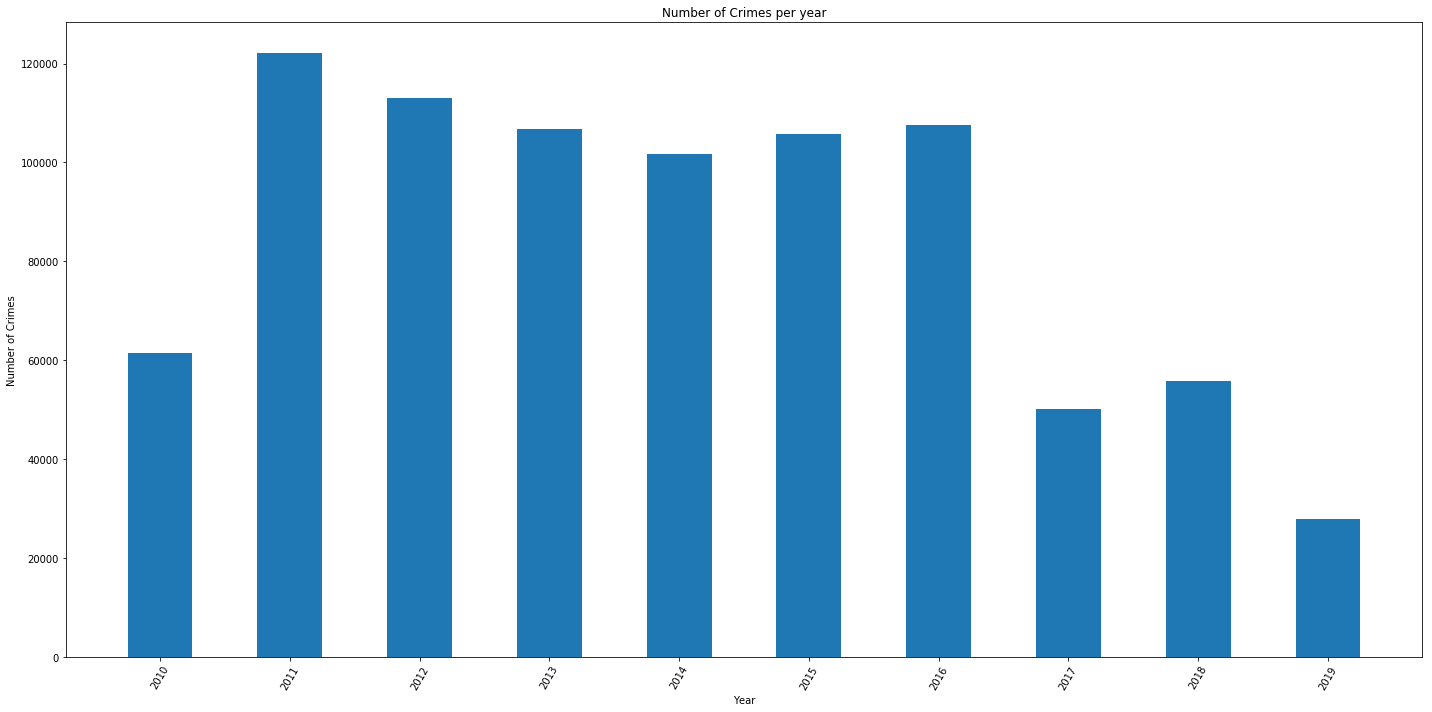

In [11]:
from pyspark.sql.functions import isnull
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import math

def change_type(date_str):
    """
    Change the String date string to single year

    Args:
        String of date

    Returns:
        Stirng of year

    """
    return date_str.split("/")[2]

# Define the udf
change_format_udfs = udf(change_type,returnType=StringType())
# romove null
crime_mongo_df = crime_mongo_df.filter(~isnull(crime_mongo_df['Reported Date']))
# change the column reported date from 08/08/2018 to 2018
new_crime_df = crime_mongo_df.withColumn('Reported Date',change_format_udfs('Reported Date'))
crime_mongo_plot_q1 = new_crime_df.groupBy('Reported Date')\
                                  .sum('Offence Count')\
                                  .orderBy('Reported Date')\
                                  .collect()
# get the year 
x_list = [row['Reported Date'] for row in crime_mongo_plot_q1]
# the the crime number
y_list = [row['sum(Offence Count)'] for row in crime_mongo_plot_q1]
bar_width = 0.5
# plot
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.bar(x_list, y_list, bar_width, align='center', color='C0')
plt.xlabel('Year')
plt.xticks(rotation=60)
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes per year')
plt.tight_layout()
plt.show()


Understanding: The largest number of crimes is around 120,000 in 2011, and the smallest number is around 30,000 in 2019. From 2010 to 2011, the number of crime increased significantly, then from 2011 to 2016 the trend is stable. Good point is that after 2017, the number of crimes decreased fastly.

Q2 Find the number of crimes per month. Plot the graph and explain your understanding of the graph.

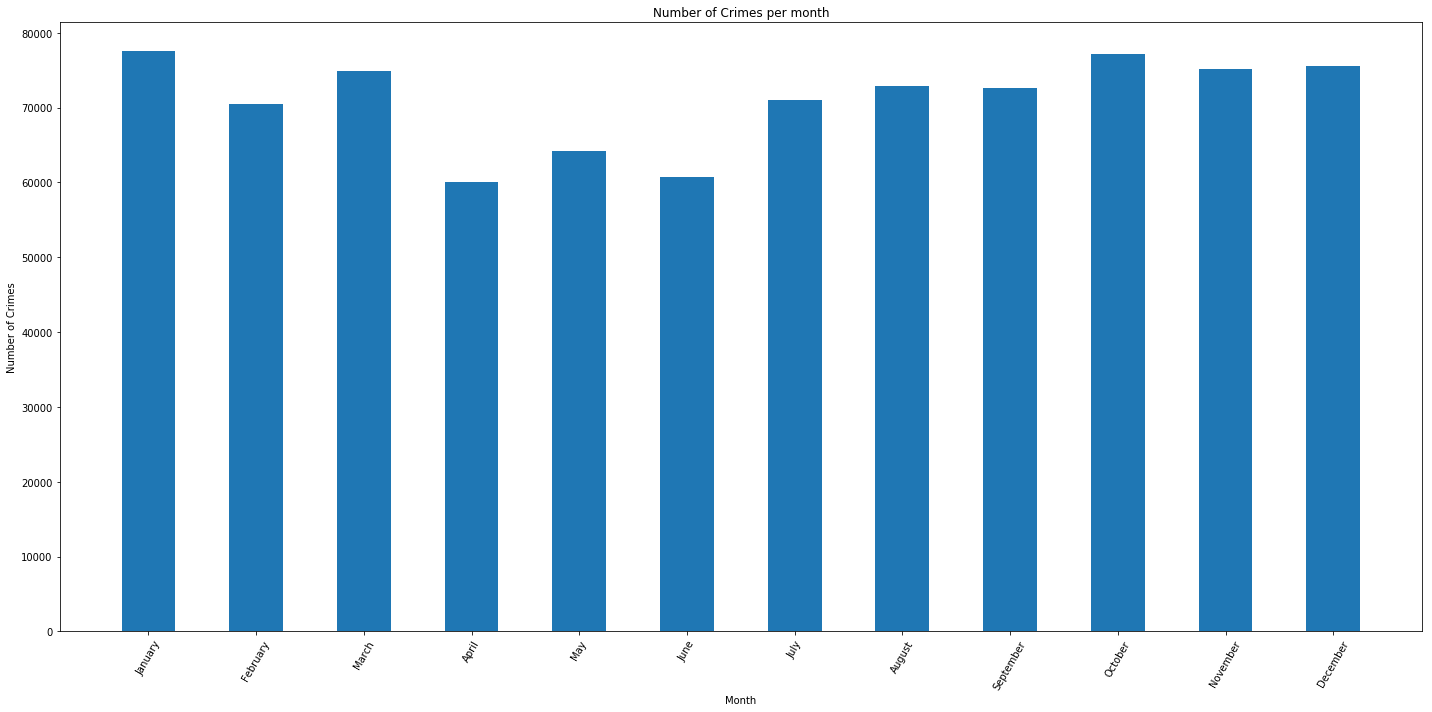

In [12]:
from pyspark.sql.functions import isnull
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import math
import calendar


def change_type_month(date_str):
    """
    Change the String date string to single year

    Args:
        String of date

    Returns:
        Stirng of year

    """
    return date_str.split("/")[1]

# Define the udf
change_format_udfs = udf(change_type_month,returnType=StringType())
# romove null
crime_mongo_df = crime_mongo_df.filter(~isnull(crime_mongo_df['Reported Date']))
# change the column reported date from 08/08/2018 to 08
new_crime_df = crime_mongo_df.withColumn('Reported Date',change_format_udfs('Reported Date'))
crime_mongo_plot_q2 = new_crime_df.groupBy('Reported Date')\
                                  .sum('Offence Count')\
                                  .orderBy('Reported Date')\
                                  .collect()
# get the year 
x_list = [row['Reported Date'] for row in crime_mongo_plot_q2]
# the the crime number
y_list = [row['sum(Offence Count)'] for row in crime_mongo_plot_q2]
x_month_list = []
for month_idx in range(1, len(x_list) + 1):
    x_month_list.append(calendar.month_name[month_idx])
bar_width = 0.5
# plot
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.bar(x_month_list, y_list, bar_width, align='center', color='C0')
plt.xlabel('Month')
plt.xticks(rotation=60)
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes per month')
plt.tight_layout()
plt.show()



Understanding: The largest number of crimes is around 78,000 in Jan, and the smallest number is around 60,000 in April. from Oct to March(Oct,Nov,Dec,Jan,Feb,Mar) the number of crime is higher than other months.

Q3 Where do most crimes take place? Find the top 20 suburbs (which would also display postcode for e.g. Caulfield-3162 )?. Plot the graph and explain your understanding of the graph.

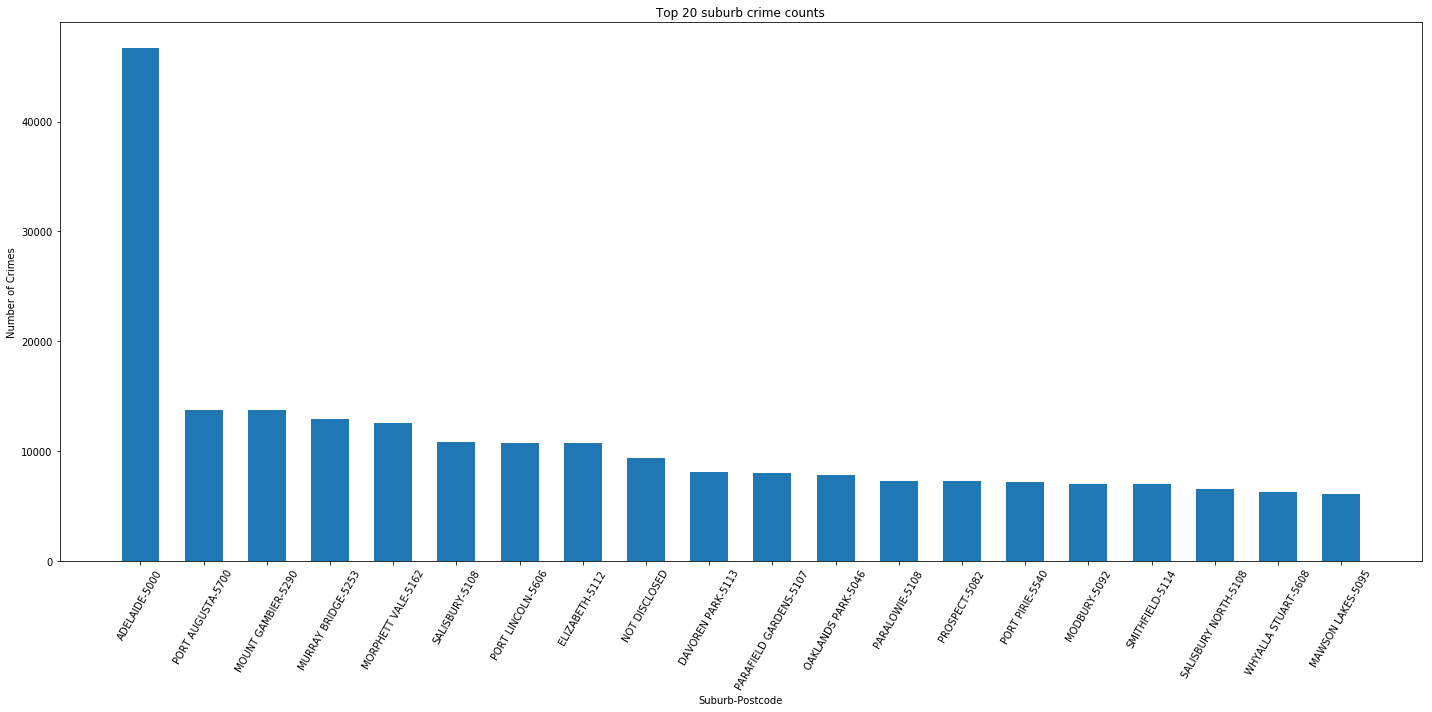

In [13]:
from pyspark.sql.functions import isnull
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


# romove null
crime_mongo_df = crime_mongo_df.filter(~isnull(crime_mongo_df['Suburb - Incident']))
crime_mongo_df = crime_mongo_df.filter(~isnull(crime_mongo_df['Postcode - Incident']))
# change the column reported date from 08/08/2018 to 08
crime_mongo_plot_q3 = crime_mongo_df.groupBy('Suburb - Incident','Postcode - Incident')\
                                    .sum('Offence Count')\
                                    .orderBy('sum(Offence Count)',ascending=False)\
                                    .take(20)

# get the suburb
suburb_list = [row['Suburb - Incident'] for row in crime_mongo_plot_q3]

# get the post code
post_list = [row['Postcode - Incident'] for row in crime_mongo_plot_q3]

x_list = []

# get x list, there is a part call "NOT DISCLOSED", I think it should also be considered, because I want to know 
# how many crimes has not been disclosed
for x in range(0,len(suburb_list)):
    if suburb_list[x] != "NOT DISCLOSED":
        string = suburb_list[x]+"-"+post_list[x]
        x_list.append(string)
    else:
        x_list.append("NOT DISCLOSED")
        
# get y axis
y_list = [row['sum(Offence Count)'] for row in crime_mongo_plot_q3]
plt.rcParams['figure.figsize'] = (20.0, 10.0)
bar_width = 0.6
# plot
plt.bar(x_list, y_list, bar_width, align='center', color='C0')
plt.xlabel('Suburb-Postcode')
plt.xticks(rotation=60)
plt.ylabel('Number of Crimes')
plt.title('Top 20 suburb crime counts')
plt.tight_layout()
plt.show()

Understanding: The number of crimes in Adelaide-5000 is significant higher than that of other suburbs, which is more thant 40,000. The number of other suburb is around 10,000. Besides, there are some crimes are not recorded as suburb, the number of these crimes is around 10,000, which ranked nine.

Q4 Find the number of serious criminal trespasses by day and month. Plot a graph and explain your understanding of the graph.

[[1722, 1661, 1609, 1366, 1598, 1416, 1663, 1821, 1824, 1889, 1784, 1697], [1681, 1376, 1486, 1245, 1359, 1230, 1386, 1419, 1452, 1692, 1421, 1401], [1513, 1325, 1338, 1110, 1163, 1137, 1400, 1457, 1437, 1552, 1381, 1390], [1412, 1260, 1442, 1134, 1266, 1204, 1273, 1344, 1445, 1403, 1420, 1375], [1524, 1376, 1436, 1175, 1273, 1190, 1442, 1426, 1475, 1553, 1532, 1419], [1246, 1118, 1224, 1020, 1045, 1009, 1268, 1133, 1184, 1331, 1209, 1278], [1309, 1143, 1310, 1097, 1138, 1071, 1334, 1223, 1295, 1384, 1330, 1280]]


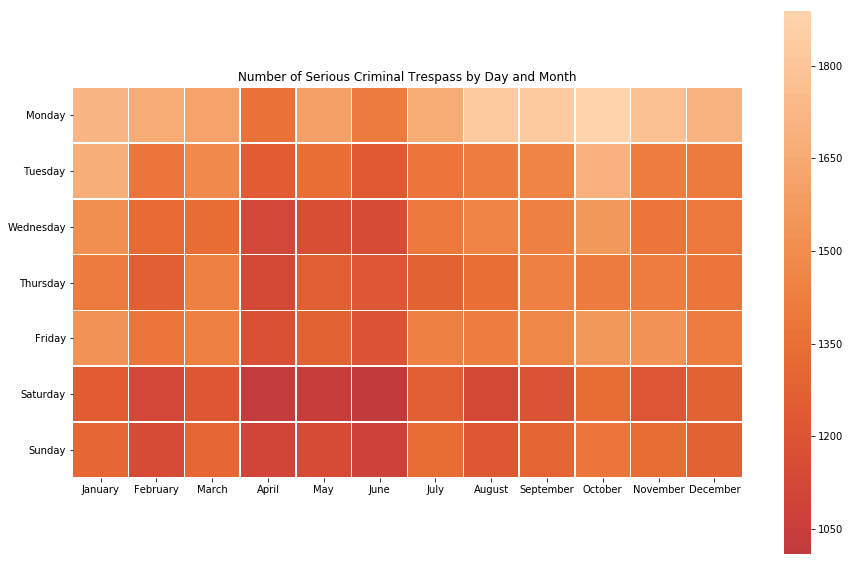

In [14]:
#### from pyspark.sql.functions import isnull
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import math
import seaborn as sns
from pyspark.sql.functions import isnull

# read from MongoDB
crime_mongo_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
question_list = []
question_list.append('SERIOUS CRIMINAL TRESPASS')
crime_mongo_df = crime_mongo_df.filter(~isnull(crime_mongo_df['Offence Level 2 Description']))
crime_mongo_df = crime_mongo_df.filter(~isnull(crime_mongo_df['Reported Date']))
crime_mongo_df = crime_mongo_df.filter(~isnull(crime_mongo_df['Offence Count']))
crime_mongo_plot_q4 = crime_mongo_df.filter(crime_mongo_df['Offence Level 2 Description'].isin(question_list))\
                                  .groupBy('Reported Date')\
                                  .sum('Offence Count')\
                                  .collect()

# get the year, month, day 
date_list = [row['Reported Date'] for row in crime_mongo_plot_q4]
# the the crime number
sum_list = [row['sum(Offence Count)'] for row in crime_mongo_plot_q4]
len_list = len(date_list)
# create mon to sun list
mon = []
tue = []
wed = []
thur = []
fri = []
sat = []
sun = []
# initalization these lists
for x in range(0,12):
    mon.append(0)
    tue.append(0)
    wed.append(0)
    thur.append(0)
    fri.append(0)
    sat.append(0)
    sun.append(0)

# 
for x in range(0,len_list):
    # get the day, month, year
    time_split = date_list[x].split("/")
    year = int(time_split[2])
    month = int(time_split[1])
    day = int(time_split[0])
    # jundge the day in week 
    anyday = int(datetime.datetime(year,month,day).strftime("%w"))
    if anyday == 1: # monday
        num = mon[month-1] + sum_list[x]
        mon[month-1] = num
    elif anyday == 2: # tuesday
        num = tue[month-1] + sum_list[x]
        tue[month-1] = num
    elif anyday == 3: # wednesday
        num = wed[month-1] + sum_list[x]
        wed[month-1] = num
    elif anyday == 4: # thursday
        num = thur[month-1] + sum_list[x]
        thur[month-1] = num
    elif anyday == 5: # friday
        num = fri[month-1] + sum_list[x]
        fri[month-1] = num
    elif anyday == 6: # saturday
        num = sat[month-1] + sum_list[x]
        sat[month-1] = num
    else: # sunday == 0
        num = sun[month-1] + sum_list[x]
        sun[month-1] = num
# from the heat map list
hatmap_list = [mon,tue,wed,thur,fri,sat,sun]
print(hatmap_list)
# y_label
week = ["Monday", "Tuesday", "Wednesday", "Thursday",
              "Friday", "Saturday", "Sunday"]
# x_label
month = []
for month_idx in range(1, 13):
    month.append(calendar.month_name[month_idx])
# size
plt.figure(figsize=(15, 10))
# heatmap 
ax = sns.heatmap(hatmap_list,center=0.8,linewidths=0.5,square =True, 
                 robust=False,annot=False,xticklabels=month,yticklabels=week)
ax.set_title("Number of Serious Criminal Trespass by Day and Month")
plt.show()

Understanding: From the heatmap presented above:
1. in the month from April to June, there are fewer serious criminal than other months
2. from October to December, thare are more serious criminal than other months
3. The largest number is on Monday in October
4. In the average, Saturday and Sunday has fewer criminals
5. In the average, Monday has more criminals